In [1]:
import sys
import pathlib
import os
from skmap.catalog import s3_setup, DataCatalog
from skmap.loader import TiledDataLoader
from eumap.mapper import SpaceOverlay
from skmap.misc import find_files, GoogleSheet, ttprint
import random
import pandas as pd
import time
import skmap_bindings as sb
import numpy as np
import geopandas as gpd
import json
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, cross_val_score, HalvingGridSearchCV, KFold, GroupKFold, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error, median_absolute_error, make_scorer
from sklearn.ensemble import RandomForestRegressor
import joblib
from pathlib import Path

folder_path = '/home/xuemeng/work_xuemeng/soc/SoilHealthDataCube'

In [4]:
# overlay depth
fn = []
    

for ii in ['_m_','_p025_','_p975_']:
    fne = [f'http://192.168.1.30:8333/tmp-eumap-ai4sh/v8/oc_iso.10694.1995.kg.m3{ii}30m_b0cm..20cm_20200101_20221231_eu_epsg.3035_v20241216.tif',
           f'http://192.168.1.30:8333/tmp-eumap-ai4sh/v8/oc_iso.10694.1995.kg.m3{ii}30m_b20cm..50cm_20200101_20221231_eu_epsg.3035_v20241216.tif',
           f'http://192.168.1.30:8333/tmp-eumap-ai4sh/v8/oc_iso.10694.1995.kg.m3{ii}30m_b50cm..100cm_20200101_20221231_eu_epsg.3035_v20241216.tif',
           f'http://192.168.1.30:8333/tmp-eumap-ai4sh/v8/oc_iso.10694.1995.kg.m3{ii}30m_b100cm..200cm_20200101_20221231_eu_epsg.3035_v20241216.tif']
    fn.extend(fne)
    
fn = [Path(ii) for ii in fn]
sub = gpd.read_file(f'/home/xuemeng/work_xuemeng/soc/visualizaiton/plot_depth.overview/plot_depth.overview_points.gpkg')
# sub = sub.to_crs(epsg=3035)
temp = SpaceOverlay(
        points=sub, 
        fn_layers=fn, verbose=True
).run()

fn = [str(a) for a in fn]
fname = ['ocd_' + a.split('_')[2] + '_' + a.split('_')[4] for a in fn]
fn = [ii.split('/')[-1][0:-4] for ii in fn]
name_map = dict(zip(fn,fname))
temp = temp.rename(columns = name_map)

temp = temp.drop(columns=['overlay_id'])

# temp.to_csv('/home/opengeohub/xuemeng/work_xuemeng/soc/visualizaiton/plot_depth.overview/plot_depth.series_points.csv',index=False)

# temp = pd.read_csv('/home/opengeohub/xuemeng/work_xuemeng/soc/visualizaiton/plot_depth.overview/plot_depth.series_points.csv')

[10:56:22] 1/12 oc_iso.10694.1995.kg.m3_m_30m_b50cm..100cm_20200101_20221231_eu_epsg.3035_v20241216
[10:56:22] 2/12 oc_iso.10694.1995.kg.m3_p025_30m_b50cm..100cm_20200101_20221231_eu_epsg.3035_v20241216
[10:56:22] 3/12 oc_iso.10694.1995.kg.m3_m_30m_b100cm..200cm_20200101_20221231_eu_epsg.3035_v20241216
[10:56:23] 4/12 oc_iso.10694.1995.kg.m3_m_30m_b20cm..50cm_20200101_20221231_eu_epsg.3035_v20241216
[10:56:24] 5/12 oc_iso.10694.1995.kg.m3_p025_30m_b100cm..200cm_20200101_20221231_eu_epsg.3035_v20241216
[10:56:24] 6/12 oc_iso.10694.1995.kg.m3_p025_30m_b0cm..20cm_20200101_20221231_eu_epsg.3035_v20241216
[10:56:24] 7/12 oc_iso.10694.1995.kg.m3_m_30m_b0cm..20cm_20200101_20221231_eu_epsg.3035_v20241216
[10:56:24] 8/12 oc_iso.10694.1995.kg.m3_p025_30m_b20cm..50cm_20200101_20221231_eu_epsg.3035_v20241216
[10:56:26] 9/12 oc_iso.10694.1995.kg.m3_p975_30m_b20cm..50cm_20200101_20221231_eu_epsg.3035_v20241216
[10:56:26] 10/12 oc_iso.10694.1995.kg.m3_p975_30m_b100cm..200cm_20200101_20221231_eu_epsg.

In [6]:
ml = ['ocd_m_b0cm..20cm', 'ocd_m_b20cm..50cm', 'ocd_m_b50cm..100cm', 'ocd_m_b100cm..200cm']
p975l = ['ocd_p975_b0cm..20cm', 'ocd_p975_b20cm..50cm', 'ocd_p975_b50cm..100cm', 'ocd_p975_b100cm..200cm']
p025l = ['ocd_p025_b0cm..20cm', 'ocd_p025_b20cm..50cm', 'ocd_p025_b50cm..100cm', 'ocd_p025_b100cm..200cm']
depth = [10,35,75,150]
depth_label = ['0-20','20-50','50-100','100-200']
temp['code'] = ['A','B','C']

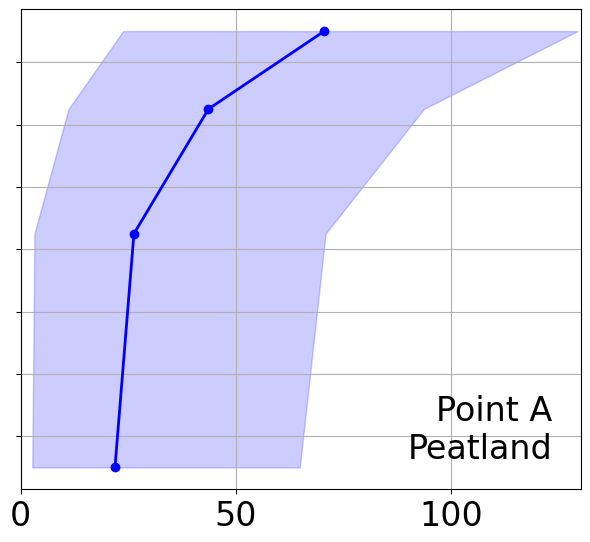

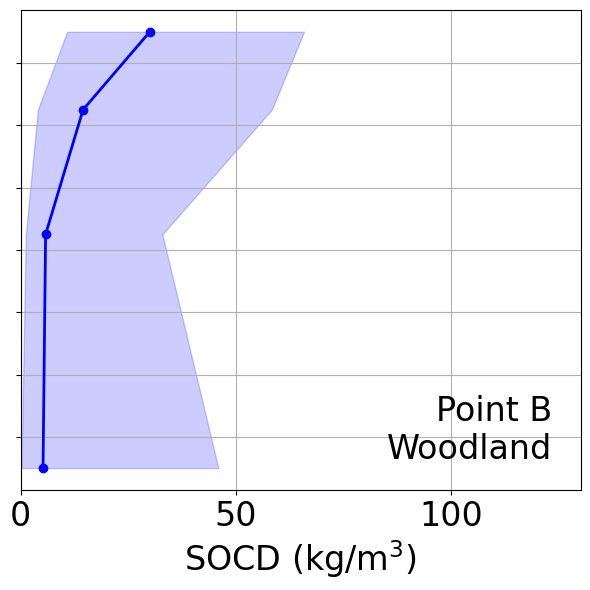

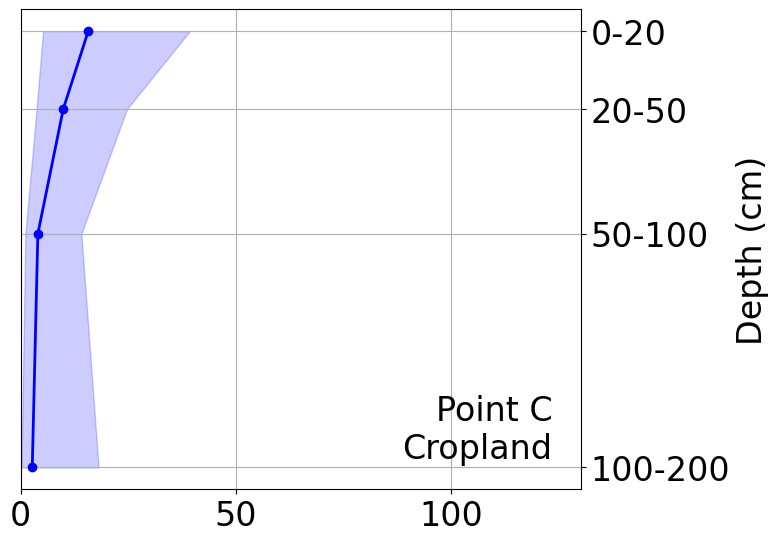

In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.gridspec import GridSpec

plot_area_width = 0.8

# Convert the columns to numeric, coercing any errors, and handle any non-numeric values
temp[ml] = temp[ml].apply(pd.to_numeric, errors='coerce')
temp[p975l] = temp[p975l].apply(pd.to_numeric, errors='coerce')
temp[p025l] = temp[p025l].apply(pd.to_numeric, errors='coerce')

# Indices of the selected rows
indices = [0, 1, 2]
points = ['A', 'B', 'C']

# Define common settings for consistent size
figsize = (7,6) 

for idx, ii in enumerate(indices):
    # Create the figure and GridSpec layout
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(1, 1, figure=fig, left=(1 - plot_area_width) / 2, right=(1 + plot_area_width) / 2, top=0.95, bottom=0.15)
    ax = fig.add_subplot(gs[0])

    mean_values = temp.iloc[ii][ml].astype(float) / 10
    upper_bounds = temp.iloc[ii][p975l].astype(float) / 10
    lower_bounds = temp.iloc[ii][p025l].astype(float) / 10

    # Plot mean values
    ax.plot(mean_values, depth, 'o-', label='Mean', color='blue', linewidth=2)

    # Use fill_betweenx for the confidence intervals
    ax.fill_betweenx(depth, lower_bounds, upper_bounds, color='blue', alpha=0.2, label='95% CI')

    # Invert y-axis to have depth increasing downwards
    ax.invert_yaxis()
    ax.grid(True)

    # Place title text at the bottom right corner
    note = temp.iloc[ii]['note']
    code = temp.iloc[ii]['code']
    ax.text(0.95, 0.05, f'Point {code}\n{note}', transform=ax.transAxes, fontsize=24, 
            verticalalignment='bottom', horizontalalignment='right')

    # Set consistent x-limits and adjust ticks
    ax.set_xlim([0,130])
    ax.tick_params(axis='x', labelsize=24)

    # Customize y-labels and ticks for the rightmost plot
    if idx == 2:
        ax.set_yticks(depth)
        ax.set_yticklabels(depth_label, fontsize=24)
        ax.set_ylabel('Depth (cm)', fontsize=24)
        ax.yaxis.set_label_position('right')
        ax.yaxis.tick_right()
    else:
        ax.tick_params(labelleft=False)  # Hide y-axis ticks and labels for the other subplots

    # Set x-axis label only for the middle plot
    if idx == 1:
        ax.set_xlabel('SOCD (kg/m$^3$)', fontsize=24)

    # Adjust margins to ensure uniform plot area
    # fig.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.2) 
    # fig.tight_layout(pad=2.0)
    # fig.set_tight_layout(True)
    # Save each plot separately
    # plt.tight_layout()
    fig.savefig(f"/home/xuemeng/work_xuemeng/soc/SoilHealthDataCube/figure/plot_{points[idx]}.svg", format='svg', bbox_inches='tight')

    # Show the plot
    plt.show()
